In [1]:
import os.path

import matplotlib.pyplot as plt
import pandas as pd
import pydicom
import torch

In [2]:
import os

df = pd.read_csv("balanced_train.csv", header=0, index_col=0)
df['exists'] = df.image_id.apply(lambda x: os.path.exists(f"data/{x}.dcm"))
df = df[df.exists]
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,exists
1787,1,11937,457443056,L,CC,79.0,1,1,0,0.0,0,A,49,False,True
33408,2,45848,2102657462,L,CC,64.0,1,1,0,NaN,0,NaN,48,False,True
25798,2,37573,1344523058,L,MLO,66.0,1,1,1,NaN,0,NaN,21,False,True
35965,1,4859,416486551,L,MLO,40.0,0,0,0,2.0,0,D,49,False,True
48775,2,62576,426711161,L,CC,56.0,0,0,0,NaN,0,NaN,29,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51207,2,65198,712545807,R,MLO,72.0,1,1,1,NaN,0,NaN,48,False,True
49804,1,63706,1241091399,R,MLO,55.0,1,1,1,0.0,0,C,93,False,True
38314,1,51115,375821057,L,CC,44.0,0,0,0,1.0,0,B,190,False,True
36844,1,4953,94584715,R,CC,65.0,1,1,0,0.0,0,B,49,False,True


In [6]:
df.density.value_counts()

density
B    574
C    541
A    111
D     60
Name: count, dtype: int64

In [9]:
clear_cases = df[df.density.isin(('A', 'B'))]
clear_cases.cancer.value_counts()

cancer
1    361
0    324
Name: count, dtype: int64

In [10]:
from PIL import Image
import numpy as np


def min_max_scale(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)


def process_image(file_path):
    file = pydicom.dcmread(file_path)
    if file.PhotometricInterpretation == "MONOCHROME1":
        pixel_data = np.invert(file.pixel_array)
    elif file.PhotometricInterpretation == "MONOCHROME2":
        pixel_data = file.pixel_array
    else:
        return None
    img = Image.fromarray(np.uint8(min_max_scale(pixel_data)*255), mode="L").resize((512, 512))
    return min_max_scale(np.asarray(img)), file.PhotometricInterpretation == "MONOCHROME2"


In [11]:
import tqdm

processed_images = []
monochrome_2 = []

for image_id in tqdm.tqdm(clear_cases.image_id):
    img, is_monochrome_2 = process_image(f"data/{image_id}.dcm")
    processed_images.append(img)
    monochrome_2.append(is_monochrome_2)

None in processed_images

100%|██████████| 685/685 [08:46<00:00,  1.30it/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [12]:
sum(monochrome_2), len(monochrome_2)

(676, 685)

True


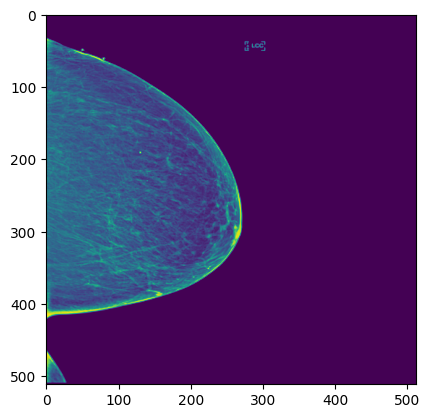

In [19]:
import matplotlib.pyplot as plt
print(monochrome_2[0])
plt.imshow(processed_images[0])

In [15]:
processed_images[0].shape

(512, 512)

In [16]:
any(f is None for f in processed_images)

False

In [18]:
clear_cases['is_mono2'] = monochrome_2
clear_cases["images"] = processed_images

/var/folders/mq/lvh6fs2s70vffqwr4lz5sy240000gn/T/ipykernel_31530/645128335.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clear_cases['is_mono2'] = monochrome_2
/var/folders/mq/lvh6fs2s70vffqwr4lz5sy240000gn/T/ipykernel_31530/645128335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clear_cases["images"] = processed_images


In [22]:
filtered_df = clear_cases[clear_cases.is_mono2]
torch.save(list(zip(filtered_df.images.to_numpy(), filtered_df.cancer.to_numpy(), filtered_df[['age', 'implant']].to_numpy().reshape((-1, 2)))),
                'filtered_preprocessed_images_with_metadata_and_target.pt')